Use the below model for **1 (a) - (c)**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Grayscale
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=ToTensor(), download=True)
svhn_train = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True)
svhn_test = torchvision.datasets.SVHN(root='./data', split='test', transform=transform, download=True)

mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)
svhn_train_loader = DataLoader(svhn_train, batch_size=128, shuffle=True)
svhn_test_loader = DataLoader(svhn_test, batch_size=128, shuffle=False)

feature_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(),
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(32, 64, 5), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.Conv2d(64, 64, 3), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

# For (b)-(c) add the task heads on top of the feature_model
# Note this model can adapt the averaging to the size so inputs of 32x32 and 28x28 both work
# Grayscale conversion for SVHN, you may use transforms.Grayscale(num_output_channels=1) found in torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
cpu


Epoch 1, Train Loss: 1.0677, Train Acc: 0.9721
Epoch 1, Test Loss: 0.6687, Test Acc: 0.9823
Epoch 2, Train Loss: 0.5131, Train Acc: 0.9824
Epoch 2, Test Loss: 0.3499, Test Acc: 0.9868
Epoch 3, Train Loss: 0.2987, Train Acc: 0.9853
Epoch 3, Test Loss: 0.2189, Test Acc: 0.9883
Epoch 4, Train Loss: 0.1972, Train Acc: 0.9878
Epoch 4, Test Loss: 0.1565, Test Acc: 0.9884
Epoch 5, Train Loss: 0.1413, Train Acc: 0.9894
Epoch 5, Test Loss: 0.1134, Test Acc: 0.9907
Epoch 6, Train Loss: 0.1081, Train Acc: 0.9904
Epoch 6, Test Loss: 0.0898, Test Acc: 0.9916
Epoch 7, Train Loss: 0.0874, Train Acc: 0.9912
Epoch 7, Test Loss: 0.0728, Test Acc: 0.9910
Epoch 8, Train Loss: 0.0719, Train Acc: 0.9919
Epoch 8, Test Loss: 0.0616, Test Acc: 0.9917
Epoch 9, Train Loss: 0.0586, Train Acc: 0.9933
Epoch 9, Test Loss: 0.0560, Test Acc: 0.9918
Epoch 10, Train Loss: 0.0507, Train Acc: 0.9935
Epoch 10, Test Loss: 0.0508, Test Acc: 0.9915
Epoch 11, Train Loss: 0.0445, Train Acc: 0.9936
Epoch 11, Test Loss: 0.0428, T

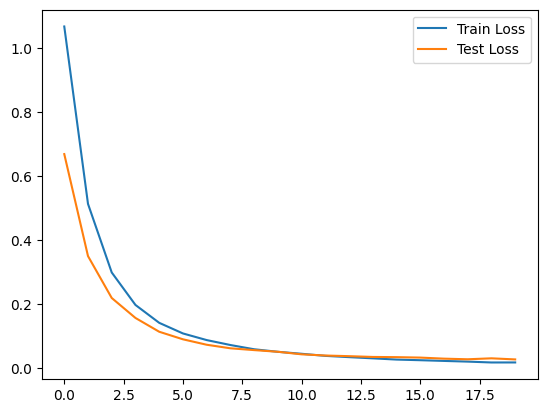

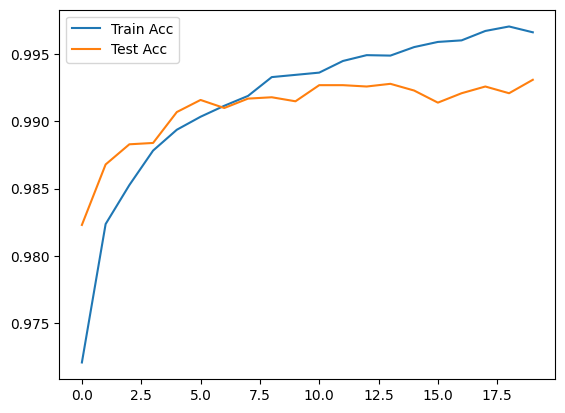

Final Test Accuracy on MNIST dataset: 0.9931


In [ ]:
model = feature_model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(20):
    train_loss = 0.0
    train_acc = 0.0
    for i, (images, labels) in enumerate(mnist_train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        train_acc += torch.sum(preds == labels)
    train_loss /= len(mnist_train_loader)
    train_acc /= len(mnist_train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in mnist_test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            test_acc += torch.sum(preds == labels)
        test_loss /= len(mnist_test_loader)
        test_acc /= len(mnist_test_loader.dataset)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

print("Training complete!")

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.legend()
plt.show()

with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in mnist_test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        total_correct += torch.sum(preds == labels)
        total_samples += len(labels)
    accuracy = total_correct / total_samples
    print(f"Final Test Accuracy on MNIST dataset: {accuracy:.4f}")

Train model on SVHN dataset

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Epoch 1, Train Loss: 2.6911, Train Acc: 0.6054
Epoch 1, Test Loss: 1.9597, Test Acc: 0.7430
Epoch 2, Train Loss: 1.6042, Train Acc: 0.7619
Epoch 2, Test Loss: 1.2963, Test Acc: 0.7998
Epoch 3, Train Loss: 1.1115, Train Acc: 0.8084
Epoch 3, Test Loss: 0.9132, Test Acc: 0.8439
Epoch 4, Train Loss: 0.8500, Train Acc: 0.8330
Epoch 4, Test Loss: 0.7172, Test Acc: 0.8635
Epoch 5, Train Loss: 0.6930, Train Acc: 0.8515
Epoch 5, Test Loss: 0.6322, Test Acc: 0.8659
Epoch 6, Train Loss: 0.5961, Train Acc: 0.8642
Epoch 6, Test Loss: 0.5579, Test Acc: 0.8728
Epoch 7, Train Loss: 0.5300, Train Acc: 0.8731
Epoch 7, Test Loss: 0.4862, Test Acc: 0.8876
Epoch 8, Train Loss: 0.4844, Train Acc: 0.8798
Epoch 8, Test Loss: 0.4573, Test Acc: 0.8886
Epoch 9, Train Loss: 0.4483, Train Acc: 0.8849
Epoch 9, Test Loss: 0.4207, Test Acc: 0.8961
Epoch 10, Train Loss: 0.4230, Train Acc: 0.8881
Epoch 1

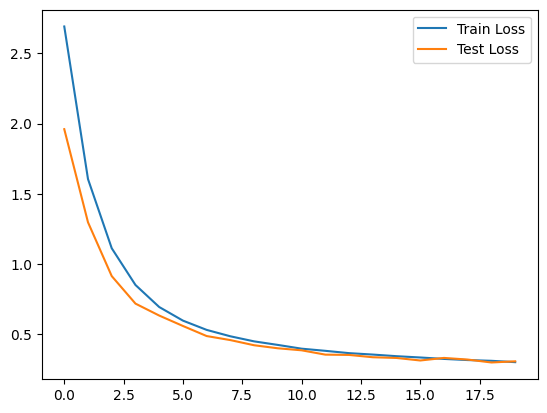

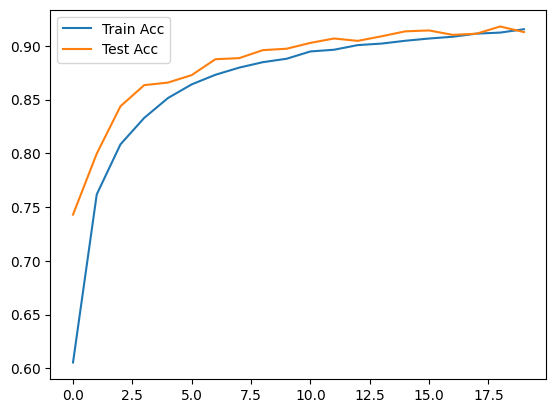

Final Test Accuracy on SVHN dataset: 0.9129


In [ ]:
model = feature_model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
])

svhn_train = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True)
svhn_test = torchvision.datasets.SVHN(root='./data', split='test', transform=transform, download=True)

svhn_train_loader = DataLoader(svhn_train, batch_size=128, shuffle=True)
svhn_test_loader = DataLoader(svhn_test, batch_size=128, shuffle=False)


train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(20):
    train_loss = 0.0
    train_acc = 0.0
    for i, (images, labels) in enumerate(svhn_train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        train_acc += torch.sum(preds == labels)
    train_loss /= len(svhn_train_loader)
    train_acc /= len(svhn_train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc.cpu())
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in svhn_test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            test_acc += torch.sum(preds == labels)
        test_loss /= len(svhn_test_loader)
        test_acc /= len(svhn_test_loader.dataset)
        test_losses.append(test_loss)
        test_accs.append(test_acc.cpu())
        print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

print("Training complete!")

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

plt.plot(train_accs,label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.legend()
plt.show()

with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in svhn_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        total_correct += torch.sum(preds == labels)
        total_samples += len(labels)
    accuracy = total_correct / total_samples
    print(f"Final Test Accuracy on SVHN dataset: {accuracy:.4f}")

##C

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Epoch 1, Train Loss Mnist: 0.1438, Train Acc Mnist: 0.9711
Epoch 1, Train Loss Svhn: 0.3305, Train Acc Svhn: 0.7235
Epoch 1, Test Loss Mnist: 0.0359, Test Acc Mnist: 0.9886
Epoch 1, Test Loss Svhn: 0.0973, Test Acc Svhn: 0.3587
Epoch 2, Train Loss Mnist: 0.0313, Train Acc Mnist: 0.9908
Epoch 2, Train Loss Svhn: 0.2067, Train Acc Svhn: 0.7576
Epoch 2, Test Loss Mnist: 0.0323, Test Acc Mnist: 0.9896
Epoch 2, Test Loss Svhn: 0.0939, Test Acc Svhn: 0.3592
Epoch 3, Train Loss Mnist: 0.0269, Train Acc Mnist: 0.9918
Epoch 3, Train Loss Svhn: 0.1916, Train Acc Svhn: 0.7630
Epoch 3, Test Loss Mnist: 0.0283, Test Acc Mnist: 0.9904
Epoch 3, Test Loss Svhn: 0.0951, Test Acc Svhn: 0.3591
Epoch 4, Train Loss Mnist: 0.0225, Train Acc Mnist: 0.9929
Epoch 4, Train Loss Svhn: 0.1855, Train Acc Svhn: 0.7650
Epoch 4, Test Loss Mnist: 0.0278, Test Acc Mnist: 0.9908
Epoch 4, Test Loss Svhn: 0

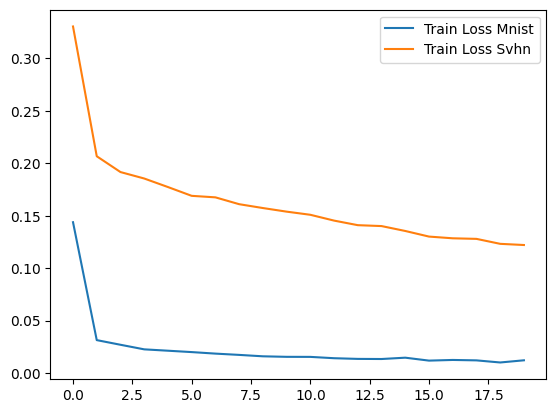

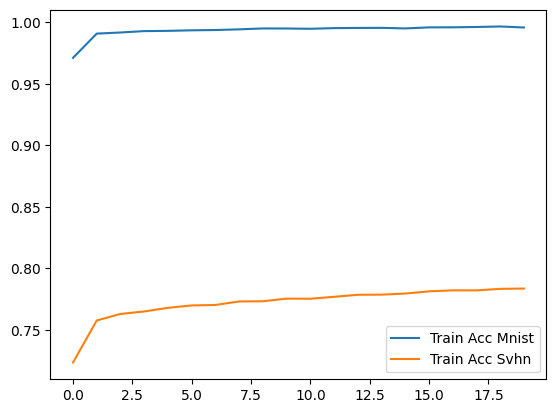

In [ ]:

# define the task-specific output heads
head_mnist = nn.Sequential(
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

head_svhn = nn.Sequential(
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Define the shared model with two heads
class SharedModel(nn.Module):
    def __init__(self, feature_model, head_mnist, head_svhn):
        super().__init__()
        self.feature_model = feature_model
        self.head_mnist = head_mnist
        self.head_svhn = head_svhn

    def forward(self, x):
        # Get features from the shared feature model
        features = self.feature_model(x)

        if len(features)==128:
          feature1 = features[:int(len(features)/2),:]
          feature2 = features[int(len(features)/2):,:]
          # Predictions for MNIST task
          mnist_out = self.head_mnist(feature1)

          # Predictions for SVHN task
          svhn_out = self.head_svhn(feature2)

        if len(features)==96:

          feature1 = features[:32,:]
          feature2 = features[32:,:]
          # Predictions for MNIST task
          mnist_out = self.head_mnist(feature1)

          # Predictions for SVHN task
          svhn_out = self.head_svhn(feature2)

        if len(features)==80:

          feature1 = features[:16,:]
          feature2 = features[16:,:]

          # Predictions for MNIST task
          mnist_out = self.head_mnist(feature1)

          # Predictions for SVHN task
          svhn_out = self.head_svhn(feature2)

        return mnist_out, svhn_out

# Create the shared model
shared_model = SharedModel(feature_model, head_mnist, head_svhn).to(device)


# define the optimizer
optimizer = optim.Adam(shared_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


# define the data loaders for each task
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale(),
])

transform2 = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform2, download=True)
svhn_train = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True)

mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform2, download=True)
svhn_test = torchvision.datasets.SVHN(root='./data', split='test', transform=transform, download=True)

mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
svhn_test_loader = DataLoader(svhn_test, batch_size=64, shuffle=False)


mnist_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
svhn_loader = DataLoader(svhn_train, batch_size=64, shuffle=True)

train_losses_mnist = []
train_accs_mnist = []
train_losses_svhn = []
train_accs_svhn = []

# train the shared model
n_epochs = 20
for epoch in range(n_epochs):
    train_loss_mnist = 0.0
    train_acc_mnist = 0.0
    train_loss_svhn = 0.0
    train_acc_svhn = 0.0
    shared_model.train()
    for (mnist_images, mnist_labels), (svhn_images, svhn_labels) in zip(mnist_loader, svhn_loader):
        # concatenate the batch from both datasets
        mnist_images = mnist_images.to(device)
        svhn_images = svhn_images.to(device)
        mnist_labels = mnist_labels.to(device)
        svhn_labels = svhn_labels.to(device)
        images = torch.cat([mnist_images, svhn_images], dim=0)
        labels1 = mnist_labels
        labels2 = svhn_labels

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        outputs1, outputs2 = shared_model(images)
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss = loss1 + loss2

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_mnist += loss1.item()
        _, preds1 = torch.max(outputs1, dim=1)
        train_acc_mnist += torch.sum(preds1 == labels1)

        train_loss_svhn += loss2.item()
        _, preds2 = torch.max(outputs2, dim=1)
        train_acc_svhn += torch.sum(preds2 == labels2)

    train_loss_mnist /= len(mnist_loader)
    train_acc_mnist /= len(mnist_loader.dataset)
    train_losses_mnist.append(train_loss_mnist)
    train_accs_mnist.append(train_acc_mnist)

    train_loss_svhn /= len(svhn_loader)
    train_acc_svhn /= len(svhn_loader.dataset)
    train_losses_svhn.append(train_loss_svhn)
    train_accs_svhn.append(train_acc_svhn)

    print(f"Epoch {epoch+1}, Train Loss Mnist: {train_loss_mnist:.4f}, Train Acc Mnist: {train_acc_mnist:.4f}")
    print(f"Epoch {epoch+1}, Train Loss Svhn: {train_loss_svhn:.4f}, Train Acc Svhn: {train_acc_svhn:.4f}")

# evaluate the shared model on MNIST and SVHN test set
    test_loss_mnist = 0.0
    test_loss_svhn = 0.0
    test_acc_mnist = 0.0
    test_acc_svhn = 0.0
    shared_model.eval()
    with torch.no_grad():
        for (mnist_images, mnist_labels), (svhn_images, svhn_labels) in zip(mnist_test_loader, svhn_test_loader):
            # concatenate the batch from both datasets
            mnist_images = mnist_images.to(device)
            svhn_images = svhn_images.to(device)
            mnist_labels = mnist_labels.to(device)
            svhn_labels = svhn_labels.to(device)
            images = torch.cat([mnist_images, svhn_images], dim=0)
            labels1 = mnist_labels
            labels2 = svhn_labels

            # zero the gradients

            # forward pass
            outputs1, outputs2 = shared_model(images)
            loss1 = criterion(outputs1, labels1)
            loss2 = criterion(outputs2, labels2)
            test_loss_mnist += loss1.item()
            _, preds1 = torch.max(outputs1, dim=1)
            test_acc_mnist += torch.sum(preds1 == labels1)

            test_loss_svhn += loss2.item()
            _, preds2 = torch.max(outputs2, dim=1)
            test_acc_svhn += torch.sum(preds2 == labels2)

        test_loss_mnist /= len(mnist_test_loader)
        test_acc_mnist /= len(mnist_test_loader.dataset)


        test_loss_svhn /= len(svhn_test_loader)
        test_acc_svhn /= len(svhn_test_loader.dataset)


        print(f"Epoch {epoch+1}, Test Loss Mnist: {test_loss_mnist:.4f}, Test Acc Mnist: {test_acc_mnist:.4f}")
        print(f"Epoch {epoch+1}, Test Loss Svhn: {test_loss_svhn:.4f}, Test Acc Svhn: {test_acc_svhn:.4f}")

plt.plot(train_losses_mnist, label="Train Loss Mnist")
plt.plot(train_losses_svhn, label="Train Loss Svhn")
plt.legend()
plt.show()
train_accs_mnist = torch.stack(train_accs_mnist)
train_accs_svhn = torch.stack(train_accs_svhn)
plt.plot(train_accs_mnist.cpu(),label="Train Acc Mnist")
plt.plot(train_accs_svhn.cpu(), label="Train Acc Svhn")
plt.legend()
plt.show()


***Question*** **1 (d)**

In this question we will train a joint embedding between a model embedding from MNIST and a model embedding from SVHN dataset, both digit datasets. Your specific task to evaluate this will be to try to obtain $70\%$ or higher accuracy on the MNIST classification by embedding MNIST test digits and then searching for the 1-nearest neighbor SVHN digit and using it's category to classify.  

First we will define the mnist and svhn models. For svhn we will use a pre-trained model that can already classify svhn digits. The models are defined below

In [ ]:
## MNIST model
import torch
import torch.nn as nn
from torchvision import transforms

model_mnist = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), #For (e) use SVHN nn.Conv2d(3,32,5)
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(32, 64, 5), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.Conv2d(64, 64, 3), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

from torch.utils import model_zoo
from collections import OrderedDict
### SVHN model, we will download one that is already trained to clasify svhn digits
model_urls = {
    'svhn': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/svhn-f564f3d8.pth',
}

class SVHN(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(SVHN, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features

        #We won't use this classifier
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        print(self.features)
        print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU(), nn.Dropout(0.3)]
            else:
                layers += [conv2d, nn.ReLU(), nn.Dropout(0.3)]
            in_channels = out_channels
    return nn.Sequential(*layers)

def svhn_model(n_channel, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel, 'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = SVHN(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['svhn'],map_location=torch.device('cpu'))
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)

    return model


base_svhn = svhn_model(n_channel=32,pretrained=True).features
svhn_to_joint = nn.Linear(256,64)

model_svhn = nn.Sequential(base_svhn, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), svhn_to_joint)


#Transformation for SVHN data, you need to use this normalization for the pre-trained model to work properly
transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (15): ReLU()
  (16): Dropout(p=0.3, inplace=False)
  (17): MaxPool2d(kernel_size=2, stride=2, padding=0

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/svhn-f564f3d8.pth" to /root/.cache/torch/hub/checkpoints/svhn-f564f3d8.pth
100%|██████████| 2.24M/2.24M [00:01<00:00, 1.25MB/s]


Let's denote model_mnist above as $f_{\theta}(x)$, the pre_trained model $g_{\gamma}$ and svhn_to_joint as the matrix $W$. Finally model_svhn corresponds to $WAg_{\gamma}(x)$. Here A (nn.AdaptiveAvgPool2d) is the averaging operator and has no parameters. Thus model_svhn will map svhn digits to a joint space and model_mnist will map MNIST digits to the joint space.  We will keep $g_{
\gamma}$ fixed and update $\theta, W$.  You should optimize the following objective that is a sum of two loss functions over triplets


$$\min_{\theta, W} \sum_{x_a,x_p,x_n \in \textbf{M}} max(0, \|f_{\theta}(x_a) - WAg_{\gamma}(x_p) \|-\|f_{\theta}(x_a) - WAg_{\gamma}(x_n) \|+\alpha) +\sum_{x_a,x_p,x_n \in \textbf{S}} max(0, \|f_{\theta}(x_p) - WAg_{\gamma}(x_a) \|-\|f_{\theta}(x_n) - WAg_{\gamma}(x_a) \|+\alpha)$$


Here $\textbf{M}$ is the set of triplets with anchors from MNIST data, positives from SVHN (matching the anchor class), and negatives from SVHN (with different class from anchors). Similarly $\textbf{S}$ is the set of triplets with anchors from SVHN data, positives from MNIST (matching anchor class), and negatives from MNIST not matching anchor class. You can use nn.TripletMarginLoss to implement this.  

During training with a stochastic optimizer we will sample subsets of $M$ and $S$ for each gradient update, there are various valid ways to sample this as will be discussed.

Note we only optimize W and $\theta$, below see an example how to build the optimizer. Note we want to freeze the $g_{\gamma}$ model so we will also need to disable the dropout and batchnorm.

In [ ]:
optimizer = torch.optim.Adam(list(model_mnist.parameters()) + list(svhn_to_joint.parameters()), lr=1e-5) # you may experiment with different learning rates
#model_svhn.eval() #IMPORTANT: BEFORE running set to eval even for training to avoid dropout, we want to keep this fixed except the final layer, otherwise training will need to be much longer

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Set up data loaders
transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
svhn_train = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True)

mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
svhn_test = torchvision.datasets.SVHN(root='./data', split='test', transform=transform, download=True)


mnist_test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)
svhn_test_loader = DataLoader(svhn_test, batch_size=2000, shuffle=False)


mnist_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)
svhn_loader = DataLoader(svhn_train, batch_size=256, shuffle=True)

triplet_loss = nn.TripletMarginLoss(margin=0.2)

# Set up training loop
num_epochs = 1
#margin = 0.5

model_mnist = model_mnist.to(device)
model_svhn = model_svhn.to(device)
test_losses = []
test_accs = []
a1 = 0
label_set = range(0,10)
model_mnist.train()
model_svhn.eval()
svhn_to_joint.train()
for epoch in range(num_epochs):
    model_mnist.train()
    model_svhn.train()
    for i, ((m_images, m_labels), (s_images, s_labels)) in enumerate(zip(mnist_loader, svhn_loader)):
        # concatenate the batch from both datasets
        a1 = a1+i
        if (a1==1000):
          break
        optimizer.zero_grad()
        if m_labels.shape == s_labels.shape:
            s_label_to_indices = {label: np.where(s_labels.numpy() == label)[0] for label in label_set}
            m_label_to_indices = {label: np.where(m_labels.numpy() == label)[0] for label in label_set}
            s_idx_pos = []
            s_idx_neg = []
            for s_lbl in s_labels:
                positive_index = np.random.choice(m_label_to_indices[s_lbl.item()])
                negative_label = np.random.choice(list(set(label_set) - set([s_lbl.item()])))
                negative_index = np.random.choice(m_label_to_indices[negative_label])
                s_idx_pos.append(positive_index)
                s_idx_neg.append(negative_index)
            m_idx_pos = []
            m_idx_neg = []
            for m_lbl in m_labels:
                positive_index = np.random.choice(s_label_to_indices[m_lbl.item()])
                negative_label = np.random.choice(list(set(label_set) - set([m_lbl.item()])))
                negative_index = np.random.choice(s_label_to_indices[negative_label])
                m_idx_pos.append(positive_index)
                m_idx_neg.append(negative_index)
            s_images = s_images.to(device)
            s_labels = s_labels.to(device)
            m_images = m_images.to(device)
            m_labels = m_labels.to(device)

            m_anchor = model_mnist(m_images)
            m_positive = model_svhn(s_images[m_idx_pos])
            m_negative = model_svhn(s_images[m_idx_neg])
            s_anchor = model_svhn(s_images)
            s_positive = model_mnist(m_images[s_idx_pos])
            s_negative = model_mnist(m_images[s_idx_neg])

            loss = triplet_loss(m_anchor, m_positive, m_negative) + triplet_loss(s_anchor, s_positive, s_negative)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

svhn_eval_loader = DataLoader(svhn_train, batch_size=2000, shuffle=True)
mnist_eval_loader = DataLoader(mnist_test, batch_size=100, shuffle=True)

s_images, s_labels = next(iter(svhn_eval_loader))
m_images, m_labels = next(iter(mnist_eval_loader))

model_svhn.eval()
model_mnist.eval()

s_embedding = model_svhn(s_images.to(device))
m_embedding = model_mnist(m_images.to(device))
with torch.no_grad():
    correct = 0
    total = m_labels.size(0)
    for i, m_embed in enumerate(m_embedding):
        min_idx = torch.norm(s_embedding - m_embed.unsqueeze(0), dim=1).argmin().item()
        correct += (m_labels[i] == s_labels[min_idx]).sum().item()
    print('The accuracy for Mnis Images is %.2f'%(100 * correct / total))

cuda
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
The accuracy for Mnis Images is 92.00


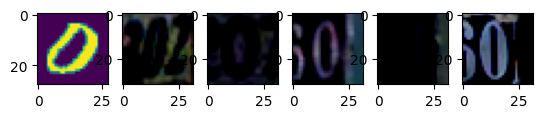

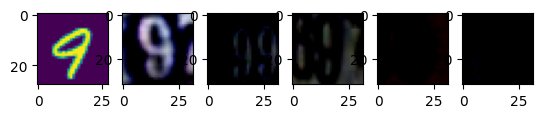

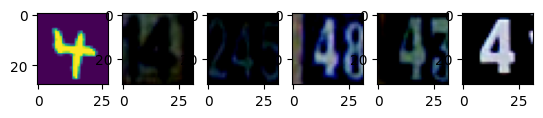

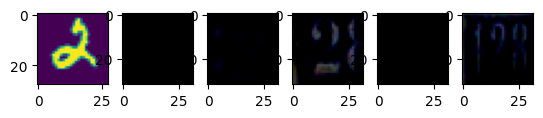

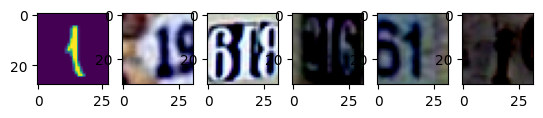

In [ ]:
model_svhn.eval()
model_mnist.eval()
M_images = m_images[0:5]
s_embedding = model_svhn(s_images.to(device))
m_embedding = model_mnist(M_images.to(device))
M = []
with torch.no_grad():
    for i, m_embed in enumerate(m_embedding):
      _, min_idx = torch.topk(torch.norm(s_embedding - m_embed.unsqueeze(0), dim=1),5,largest=False, sorted=False)
      M.append(min_idx)
      M1 = torch.stack(M).squeeze().cpu()
      plt.figure()
      plt.subplot(161)
      plt.imshow(M_images[i].permute(1,2,0))
      plt.subplot(162)
      plt.imshow(s_images[M1[0]].permute(1,2,0))
      plt.subplot(163)
      plt.imshow(s_images[M1[1]].permute(1,2,0))
      plt.subplot(164)
      plt.imshow(s_images[M1[2]].permute(1,2,0))
      plt.subplot(165)
      plt.imshow(s_images[M1[3]].permute(1,2,0))
      plt.subplot(166)
      plt.imshow(s_images[M1[4]].permute(1,2,0))
      plt.show()
      M = []

**Suggested settings:** learning rate 1e-5 with Adam, margin ($\alpha$) of 0.2, batch size: 256 triplets samples $M$ and 256 from $S$, 1000 training iterations (not epochs, but gradient updates/minibatch processed, aka it can be trained fast!). You may modify these as you see fit.

Data augmentation is not required to make this work but you may use it if you like. For SVHN you must use the normalization above (transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))) so that the pre-trained SVHN model works.

**Sampling the triplets** There are various valid ways you could construct the triplet sets $\textbf{M, S}$ and sample from them. For example you could enumerate all possible triplets over the dataset and select batches of these. A quick and dirty on the fly method that allows to use standard dataloaders is as follows: Sample a minibatch of size N (say 256) from both SVHN and MNIST using standard dataloaders from classification tasks. Treat all SVHN digits in this batch as  anchors, from the MNIST minibatch data find appropriate positives and negatives for each SVHN digit. For the second part of the loss treat the MNIST data as anchors and find negatives and postivies from the SVHN minibatch. Partial code snippets to construct this is shown below (note this code would give triplets for $\textbf{M}$ part only). You may also use your own approach to sample the triplet sets.

Note: if you would like to use hard negative mining (not required) a more sophisticated approach would be needed. Below is a code snippet example of how one could pick the positives using the labels for each minibatch.

In [ ]:
#s_labels is a vector with batch_size labels (0-9) for a minibatch of SVHN digits
#m_labels is a vector with batch_size labels (0-9) for a minibatch of MNIST digits
import numpy as np

label_set = range(0,10)
label_to_indices = {label: np.where(s_labels.cpu().numpy() == label)[0]
                            for label in label_set}


idx_pos = []
idx_neg = []
for lab in m_labels:
    positive_index = np.random.choice(label_to_indices[lab.item()])
    negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
    negative_index = np.random.choice(label_to_indices[negative_label])

    idx_pos.append(positive_index)
    idx_neg.append(negative_index)

#idx_pos and idx_neg can now can now be used to index the MNIST data minibatch to give positives and negatives


**Evaluation** For evaluating your embeddings use 2000 randomly selected SVHN digits from the SVHN training set embedding them with model_svhn. Use 100 randomly selected MNIST digits from the MNIST TEST set embedding them with model_mnist. The above numbers are chosen to avoid memory issues and reduce computation time, you may use larger amount of test inputs and embeddings if you wish. Assume the category data for the SVHN data is known and find for each MNIST digit the nearest SVHN digit. Report it's category as the prediction and compute the accuracy over all 100 MNIST digits. You should be able to obtain at least 70%+ although much higher accuracy is possible with a well tuned model.

Finally for 3-5 MNIST digits show the top 5 SVHN sorted by lowest distance.

If you run into memory issues you can move your model to CPU to process the SVHN encodings.

**Question Grading** If you have trouble getting this to work you may still get partial credit for appropriate methodology. Grading for this question will be as follows:

10 points - appropriate triplet construction and loss function construction

10 points - appropriate nearest neighbor classification evaluation setup

10 points - obtaining above 70% accuracy, 5 points for getting above 50%

10 points  - visualization of the retrieval

### 2

In [ ]:
!pip install pytorch-pretrained-biggan
!pip install libsixel-python
import nltk
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for libsixel-python: filename=libsixel_python-0.5.0-py3-none-any.whl size=12276 sha256=54696ba143b9c86eddabe22a4df4b2f2b4eac64c766024f7b6ce153b3a4cd666
  Stored in directory: /root/.cache/pip/wheels/97/40/ef/564248af8bb5891d2eb64cd79e4e27cdf6c980702251c71b0f
Successfully built libsixel-python


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256')

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom','fox','dog','lion'], batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to(device)
class_vector = class_vector.to(device)
model.to(device)

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

We visualize the generated images

torch.Size([6, 128])
torch.Size([6, 1000])


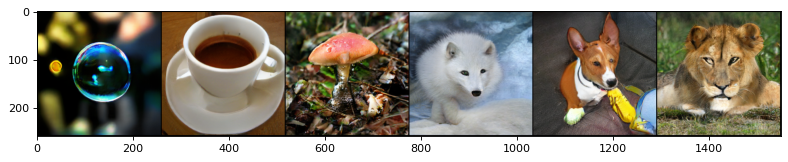

In [ ]:
output.shape
print(noise_vector.shape)
print(class_vector.shape)
plt.figure(figsize=(12, 6), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

Let's experiment with interpolating between different images in this model as we did in the face images. Note the BigGAN takes both a class vector and a random noise. (a) Sample two random images from the same category such as "dog" and interpolate between them with 8 intermediate steps and using the same class vector (b) Sample two random images from two diff classes (e.g. "dog" and "mushroom") and interpolate between them. For the class conditionin variable you may interpolate between these as well for best results.

Feel free to try other combinations and categories.

Example of what your answer shoudl look like are below. however you should show it for a different images then the ones below (And different ones than your classmates :))

torch.Size([10, 128])
torch.Size([10, 1000])


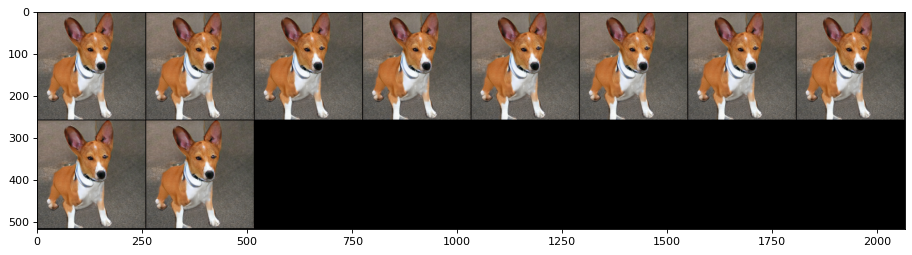

In [ ]:
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom','fox','dog','lion'], batch_size=6)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)
alpha = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]
# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

noises1 = [noise_vector[4]*a+noise_vector[4]*(1.0-a) for a in alpha]
noises1 = torch.vstack(noises1)

classes = [class_vector[4]*a+class_vector[4]*(1.0-a) for a in alpha]
classes = torch.vstack(classes)

# If you have a GPU, put everything on cuda
noises1 = noises1.to(device)
classes = classes.to(device)
model.to(device)

# Generate an image
with torch.no_grad():
    output = model(noises1, classes, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')
print(noises1.shape)
print(classes.shape)
plt.figure(figsize=(14, 8), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

torch.Size([10, 128])
torch.Size([10, 1000])
torch.Size([10, 3, 256, 256])


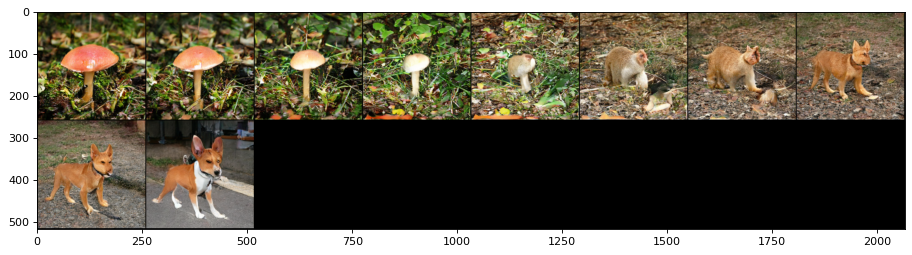

In [ ]:
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom','fox','dog','lion'], batch_size=6)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)
alpha = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]
# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

noises1 = [noise_vector[4]*a+noise_vector[2]*(1.0-a) for a in alpha]
noises1 = torch.vstack(noises1)

classes = [class_vector[4]*a+class_vector[2]*(1.0-a) for a in alpha]
classes = torch.vstack(classes)

# If you have a GPU, put everything on cuda
noises1 = noises1.to(device)
classes = classes.to(device)
model.to(device)

# Generate an image
with torch.no_grad():
    output = model(noises1, classes, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')
print(noises1.shape)
print(classes.shape)
print(output.shape)
plt.figure(figsize=(14, 10), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()